In [2]:
import numpy as np
import pandas as pd

data = "/mnt/d/Data/Instacart/"

In [3]:
f = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "train")
#f.drop(['user_prod_recentlydiscovered'], axis=1, inplace=True)
f['aisle_id'] = f.aisle_id.astype('category')
f['department_id'] = f.department_id.astype('category')
f['order_dow'] = f.order_dow.astype('category')
f['order_hour_of_day'] = f.order_hour_of_day.astype('category')
f['user_prod_reordered'] = f.user_prod_reordered.astype('category')
f['user_prod_recentlydiscovered'] = f.user_prod_recentlydiscovered.astype('category')

train = f[f['seed']<2].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)
valid = f[f['seed']==3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)

valid_label = f[['order_id', 'user_id', 'product_id', 'label']][f['seed']==3]

del f

In [6]:
train.head()

,label,second_order_ratio,avg_reorder_ratio,aisle_id,department_id,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq,user_reorder_ratio,...,user_avg_items,user_interval_avg,order_dow,order_hour_of_day,days_since_prior_order,product_week_prob,product_hour_prob,user_week_prob,user_hour_prob,user_days_since_prior_ratio
0,1,0.582500,4.473875,77,7,10,1.0,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.152580,0.059652,0.3,0.2,0.736842
2,0,0.529482,3.857058,23,19,10,1.0,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.130173,0.065318,0.3,0.2,0.736842
11,0,0.527426,3.082390,24,4,1,0.1,6,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.120317,0.069885,0.3,0.2,0.736842
12,0,0.495725,2.856348,24,4,1,0.1,6,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.111541,0.065484,0.3,0.2,0.736842
15,1,0.634271,4.278772,45,19,1,0.1,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.130106,0.052002,0.3,0.2,0.736842


<hr/>

Training using lightgbm



In [4]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'])
V = lgb.Dataset(valid.drop('label', axis=1), valid['label'], reference=X)

In [5]:
from sklearn.metrics import f1_score, roc_auc_score


TH = 0.20

def f1(preds, train_data):
    Yt = train_data.get_label()
    return 'f1', f1_score(Yt, preds>TH), True

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 63,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

evals_result = {}

In [6]:
gbdt = lgb.train(params, X, valid_sets=V, feval=f1, evals_result=evals_result)

[1]	valid_0's auc: 0.81588	valid_0's f1: 0.179016
[2]	valid_0's auc: 0.822671	valid_0's f1: 0.179016
[3]	valid_0's auc: 0.824838	valid_0's f1: 0.179016
[4]	valid_0's auc: 0.825364	valid_0's f1: 0.179016
[5]	valid_0's auc: 0.825667	valid_0's f1: 0.179016
[6]	valid_0's auc: 0.825711	valid_0's f1: 0.179016
[7]	valid_0's auc: 0.825839	valid_0's f1: 0.179016
[8]	valid_0's auc: 0.82664	valid_0's f1: 0.179016
[9]	valid_0's auc: 0.827085	valid_0's f1: 0.179016
[10]	valid_0's auc: 0.827603	valid_0's f1: 0.253665
[11]	valid_0's auc: 0.828199	valid_0's f1: 0.309452
[12]	valid_0's auc: 0.828429	valid_0's f1: 0.346027
[13]	valid_0's auc: 0.828703	valid_0's f1: 0.371935
[14]	valid_0's auc: 0.828829	valid_0's f1: 0.386834
[15]	valid_0's auc: 0.829354	valid_0's f1: 0.398448
[16]	valid_0's auc: 0.829558	valid_0's f1: 0.407362
[17]	valid_0's auc: 0.829781	valid_0's f1: 0.413607
[18]	valid_0's auc: 0.830008	valid_0's f1: 0.419206
[19]	valid_0's auc: 0.830176	valid_0's f1: 0.423259
[20]	valid_0's auc: 0.8

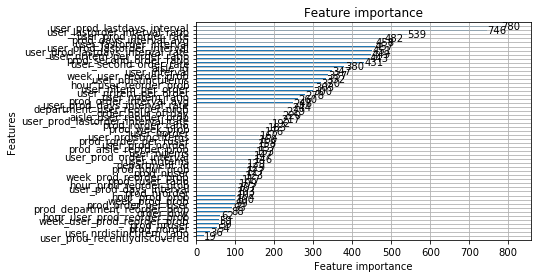

In [7]:
import matplotlib.pyplot as plt

ax = lgb.plot_importance(gbdt)
plt.show()

In [7]:
gbdt.save_model("model.cv.txt")

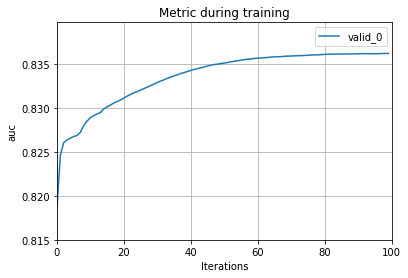

In [12]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [8]:
Yt = gbdt.predict(valid.drop('label', axis=1))

In [32]:
valid_label['pred'] = np.require(Yt>TH, dtype=np.int)
valid_label['pred_prob'] = Yt

In [36]:
from sklearn.metrics import log_loss

grpf1 = lambda x: pd.Series(data={
    'f1': 1.0
}) if not (x.label.any() or x.pred.any()) else pd.Series(data={
    'f1': f1_score(x.label, x.pred)
})

f1 = valid_label[['user_id', 'label', 'pred', 'pred_prob']].groupby(by='user_id').apply(grpf1)
valid_label = valid_label.merge(f1, left_on='user_id', right_index=True).sort_values('f1')


/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ike/.miniconda3/envs/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
valid_label.to_csv("DSATdebug.tsv", sep='\t', index=False)

In [35]:
valid_label.drop('f1', axis=1, inplace=True)

<hr/>

predict and submit

In [15]:
f1_score([0,0,0], [0,0,0])

0.0

In [2]:
test = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "test")
#test.drop(['user_prod_recentlydiscovered'], axis=1, inplace=True)

In [4]:
train = train.append(valid)

In [12]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'], categorical_feature=['aisle_id', 'department_id', 'order_dow', 'order_hour_of_day', 'user_prod_reordered'])


In [13]:
gbdt = lgb.train(params, X, num_boost_round=160)

In [3]:
import lightgbm as lgb

In [4]:
gbdt = lgb.Booster(model_file="model.txt")

In [5]:
Y = gbdt.predict(test.drop(['order_id', 'user_id', 'product_id'], axis=1))

In [10]:
test['label'] = Y>0.5

In [11]:
Y

array([ 0.78030924,  0.90250989,  0.67640252, ...,  0.2185149 ,
        0.17646151,  0.29155882])

In [12]:
d = dict()
for row in test.itertuples():
    if row.label:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

In [13]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('result.csv', index=False)

In [21]:
train

,label,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1,0.582500,4.473875,0.759259,14.0,10,1.000000,1,1.000000
2,0,0.529482,3.857058,0.759259,14.0,10,1.000000,1,1.000000
11,0,0.527426,3.082390,0.759259,14.0,1,0.100000,6,1.000000
12,0,0.495725,2.856348,0.759259,14.0,1,0.100000,6,1.000000
15,1,0.634271,4.278772,0.759259,14.0,1,0.100000,1,1.000000
18,0,0.582500,4.473875,0.515000,28.0,1,0.030303,24,1.000000
24,0,0.543279,3.699053,0.515000,28.0,5,0.151515,1,0.172414
26,0,0.487881,3.049811,0.515000,28.0,1,0.030303,13,1.000000
29,0,0.557770,3.134867,0.515000,28.0,1,0.030303,24,1.000000
30,0,0.564679,4.197768,0.515000,28.0,3,0.090909,6,0.230769
